In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Reading records and annotations

In [2]:
record_id = 'I01'
segment_len = 2000
start=0
end=start+segment_len
record_path = '../incartDb/'+record_id

In [3]:
# Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
#record = wfdb.rdrecord(record_path, sampfrom=start, sampto=end) 
#wfdb.plot_wfdb(record=record, annotation=annotation,
#               title='Record I01',
#               time_units='seconds', figsize=(10,20))
#print(record.__dict__)

signal, fields = wfdb.rdsamp(record_path, sampfrom=start, sampto=end, channels=[0,9]) 
data = np.mean(signal, axis=1)
fs = fields['fs']

## Write record into .csv file

In [4]:
time = np.linspace(0, segment_len/fs, segment_len)
print(len(time))
time

2000


array([0.00000000e+00, 3.89299708e-03, 7.78599416e-03, ...,
       7.77431517e+00, 7.77820817e+00, 7.78210117e+00])

In [5]:
file = pd.DataFrame()
file['timestamp'] = time
file['ecg_measurement'] = data
file

timestamp  ecg_measurement
0      0.000000        -0.138889
1      0.003893        -0.147059
2      0.007786        -0.125817
3      0.011679        -0.078431
4      0.015572        -0.075163
5      0.019465        -0.068627
6      0.023358        -0.044118
7      0.027251         0.013072
8      0.031144         0.027778
9      0.035037         0.039216
10     0.038930         0.042484
11     0.042823         0.065359
12     0.046716         0.081699
13     0.050609         0.045752
14     0.054502         0.031046
15     0.058395         0.016340
16     0.062288        -0.014706
17     0.066181        -0.080065
18     0.070074        -0.117647
19     0.073967        -0.150327
20     0.077860        -0.166667
21     0.081753        -0.189542
22     0.085646        -0.202614
23     0.089539        -0.222222
24     0.093432        -0.251634
25     0.097325        -0.253268
26     0.101218        -0.261438
27     0.105111        -0.259804
28     0.109004        -0.253268
29     0.112897        -0.248366
...         ...              ...
1970   7.669204        -0.047386
1971   7.673097        -0.057190
1972   7.676990        -0.052288
1973   7.680883        -0.060458
1974   7.684776        -0.065359
1975   7.688669        -0.063725
1976   7.692562        -0.047386
1977   7.696455        -0.058824
1978   7.700348        -0.096405
1979   7.704241        -0.138889
1980   7.708134        -0.150327
1981   7.712027        -0.183007
1982   7.715920        -0.236928
1983   7.719813        -0.310458
1984   7.723706        -0.369281
1985   7.727599        -0.416667
1986   7.731492        -0.405229
1987   7.735385        -0.403595
1988   7.739278        -0.390523
1989   7.743171        -0.372549
1990   7.747064        -0.390523
1991   7.750957        -0.388889
1992   7.754850        -0.370915
1993   7.758743        -0.357843
1994   7.762636        -0.356209
1995   7.766529        -0.331699
1996   7.770422        -0.344771
1997   7.774315        -0.359477
1998   7.778208        -0.369281
1999   7.782101        -0.354575

[2000 rows x 2 columns]

In [6]:
file_name = '/tmp/incartDb_' + record_id + '_' + str(start) + '.csv'
file.to_csv(file_name, index=False)

## Peak detection with `qrs_detector` from c-labpl

In [7]:
import sys
sys.path.insert(0, '/home/singuyen/project_biosignal/c-labpl.qrs_detector.master')

from QRSDetectorOffline import QRSDetectorOffline

qrs peaks indices
[ 125  288  453  617  951 1116 1280 1442 1604 1766 1926]
noise peaks indices
[]


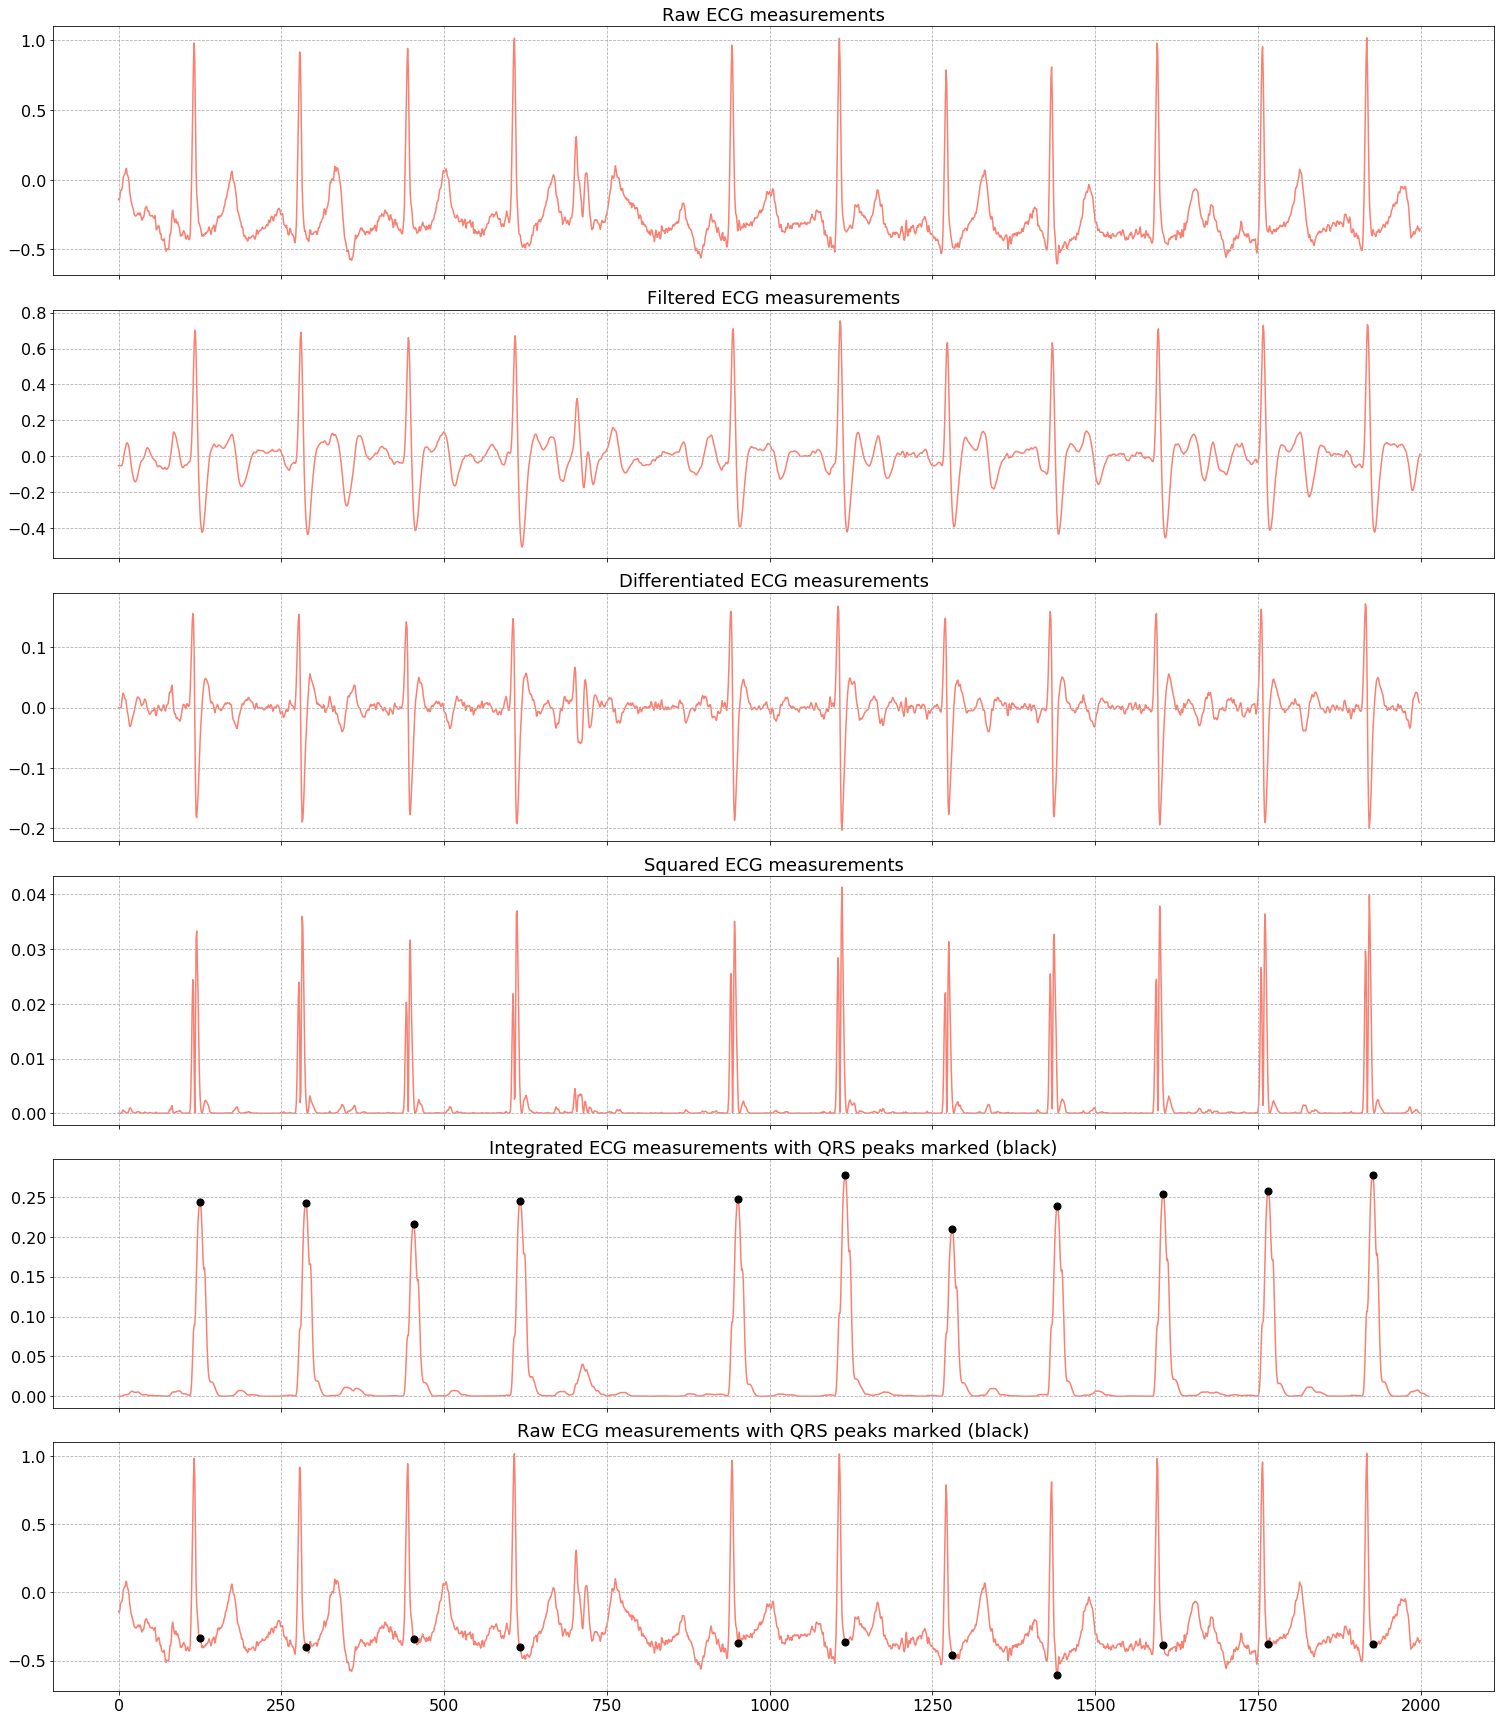

In [8]:
qrs_detector = QRSDetectorOffline(ecg_data_path=file_name, fs=fs, 
                                  findpeaks_limit=0.01, findpeaks_spacing_factor=0.2,
                                  verbose=True,
                                  log_data=False, plot_data=True, show_plot=True)

In [9]:
qrs_detector.detected_peaks_indices

array([ 125,  288,  453,  617,  713,  951, 1116, 1280, 1442, 1604, 1766,
       1926])

## Validation

In [10]:
detected_inds = qrs_detector.qrs_peaks_indices
detected_inds

array([ 125,  288,  453,  617,  951, 1116, 1280, 1442, 1604, 1766, 1926])

In [11]:
detected_inds + start

array([ 125,  288,  453,  617,  951, 1116, 1280, 1442, 1604, 1766, 1926])

In [12]:
annotation = wfdb.rdann(record_path, 'atr', sampfrom=start, sampto=end)
annotation.sample

array([ 114,  277,  442,  608,  710,  941, 1106, 1269, 1435, 1596, 1756,
       1914])

In [13]:
# Compare detected qrs complexes to reference annotation.
comparitor = processing.compare_annotations(ref_sample = annotation.sample,
                                            test_sample = detected_inds+start,
                                            window_width = int(0.1 * fs),
                                            signal = signal)

# Print the results
comparitor.print_summary()

12 reference annotations, 11 test annotations

True Positives (matched samples): 11
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 1

Specificity: 0.9167 (11/12)
Positive Predictivity: 1.0000 (11/11)
False Positive Rate: 0.0000 (0/11)
